# RNA Binding Basics: Deterministic and stochastic simulations of RNA binding

In [6]:
from copy import deepcopy
import os
import sys

import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.style.use('seaborn-v0_8')
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import jax

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.1"
os.environ["TF_CPP_MIN_LOG_LOVEL"] = "0"
jax.config.update('jax_platform_name', 'cpu')

from bioreaction.simulation.basic_sim import basic_de_sim, convert_model, BasicSimParams, BasicSimState
from bioreaction.model.data_tools import construct_model_fromnames
from bioreaction.model.data_containers import Impulse
from bioreaction.simulation.med_sim import get_int_med_model, simulate_chunk, MedSimParams, MedSimInternelState


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)

from tests.shared import five_circuits, CONFIG

config = deepcopy(CONFIG)

In [7]:
num_species = 3
# num_boundspecies = np.math.factorial(3)
signal_species_idx = 0
a = np.array([1, 1, 1])
d = np.array([1, 1, 1])
ka = np.asarray(
        [[1, 2, 1],
         [2, 1, 1],
         [1, 1, 1]])
kd = np.asarray(
        [[2, 1, 1],
         [1, 1, 1],
         [1, 1, 3]])

params = BasicSimParams(delta_t=0.01, total_time=100)



In [8]:
model = construct_model_fromnames([str(i) for i in range(num_species)])
model.species

[Species: ('0', '0'),
 Species: ('0', '1'),
 Species: ('0', '2'),
 Species: ('1', '1'),
 Species: ('1', '2'),
 Species: ('2', '2'),
 Species: 0,
 Species: 1,
 Species: 2]

In [9]:

for i, r in enumerate(model.reactions):
    if not r.input: # 0 -> RNA
        model.reactions[i].forward_rate = a[model.species[-num_species:].index(r.output[0])]
        model.reactions[i].reverse_rate = 0
    elif not r.output: # RNA -> 0
        model.reactions[i].forward_rate = d[model.species[-num_species:].index(r.input[0])]
        model.reactions[i].reverse_rate = 0
    else:
        model.reactions[i].forward_rate = ka[model.species[-num_species:].index(r.input[0]),
                                             model.species[-num_species:].index(r.input[1])]
        model.reactions[i].reverse_rate = kd[model.species[-num_species:].index(r.input[0]),
                                             model.species[-num_species:].index(r.input[1])]

sim_model = convert_model(model)

In [10]:
s0 = np.concatenate([np.zeros(len(model.species[:-num_species])), [1, 1, 1]])
starting_state = BasicSimState(concentrations=s0)

state = basic_de_sim(starting_state=starting_state, model=sim_model, params=params)
results_species = np.concatenate([np.expand_dims(starting_state.concentrations, axis=0), state[1]])[:, -num_species:]
t = np.arange(params.total_time / params.delta_t) * params.delta_t


2023-03-02 11:40:40.039901: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_asm_compiler.cc:61] cuLinkAddData fails. This is usually caused by stale driver version.
2023-03-02 11:40:40.039928: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:1369] The CUDA linking API did not work. Please use XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1 to bypass it, but expect to get longer compilation time due to the lack of multi-threading.


XlaRuntimeError: UNKNOWN: no kernel image is available for execution on the device
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_asm_compiler.cc(64): 'status'

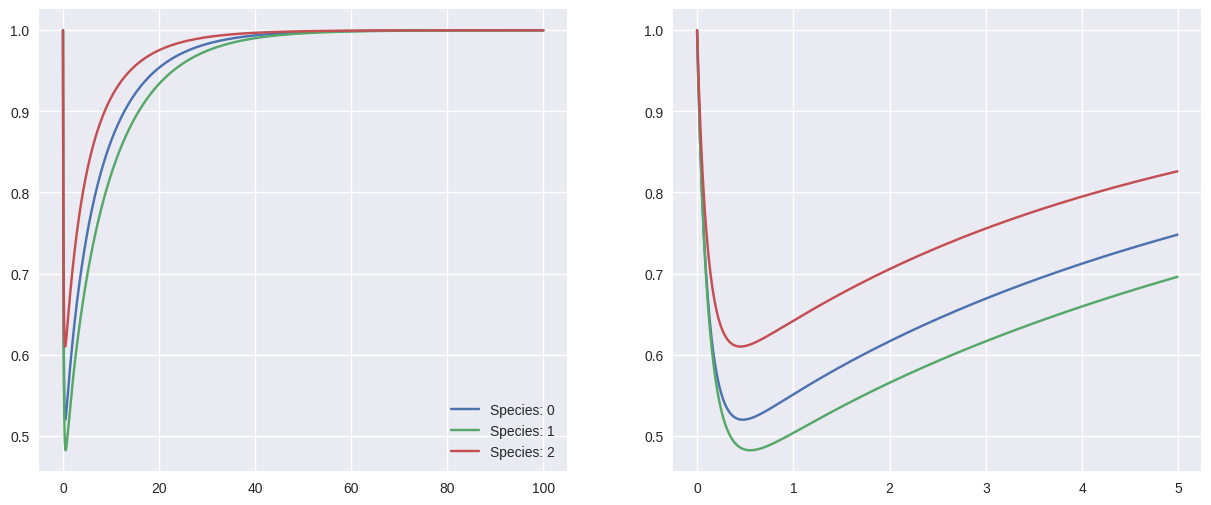

In [ ]:
plt.figure(figsize=(15, 6))
ax = plt.subplot(1,2,1)
plt.plot(t, results_species)
plt.legend(model.species[-num_species:])

ax = plt.subplot(1,2,2)
till = int(5 / params.delta_t)
plt.plot(t[:till], results_species[:till, :])


## As med sim

In [ ]:

import bioreaction
med_model = bioreaction.templates.generate_rnabinding_medsim(
    num_species=3,
    a=a,
    d=d,
    ka=ka,
    kd=kd,
    impulse_idx=0
)
poiss_simmed = jnp.zeros(len(med_model.reactions))
brown_simmed = jnp.ones(len(med_model.reactions))

# Making the params for the simulation, how things are simutated and for how long.
int_med_params = MedSimParams(delta_t= 0.01, t_start=0.0, t_end = 50.0, poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)


In [ ]:
int_med_model = get_int_med_model(med_model)

int_med_state = MedSimInternelState(concentrations=jnp.array(starting_state.concentrations), other_factors=jnp.zeros(len(med_model.other_factors)))


In [ ]:
key = jr.PRNGKey(0)
result_1 = simulate_chunk(key, int_med_state, int_med_model, int_med_params)

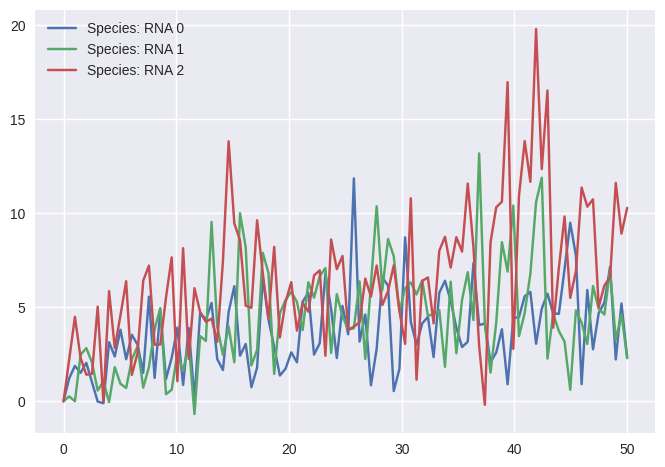

In [ ]:

plt.plot(result_1.ts, np.array(result_1.ys.concentrations)[:, :3], label=[str(s) for s in med_model.species[:3]])
plt.legend()

In [ ]:
def to_vmap_1(rng):
    return simulate_chunk(rng, int_med_state, int_med_model, int_med_params)

vmap_sim1 = jax.jit(jax.vmap(to_vmap_1))

rng_keys = jr.split(key, 100)

big_result_1 = vmap_sim1(rng_keys)

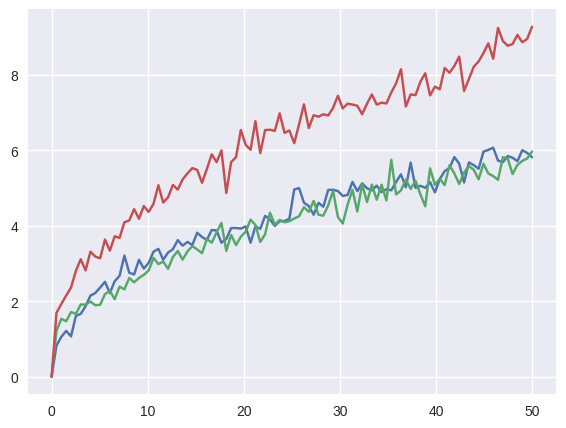

In [ ]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)
plt.plot(big_result_1.ts[0], jnp.mean(np.array(big_result_1.ys.concentrations)[:, :, :3], axis = 0))


## Adding Impulse

In [ ]:
impulse = Impulse(target=med_model.species[:num_species][signal_species_idx], delta_target=40, time=10.0, impulse_width=0.5)

med_model.impulses = [impulse]

In [ ]:
int_med_model = get_int_med_model(med_model)

result_2 = simulate_chunk(key, int_med_state, int_med_model, int_med_params)

def to_vmap_1(rng):
    return simulate_chunk(rng, int_med_state, int_med_model, int_med_params)
vmap_sim1 = jax.jit(jax.vmap(to_vmap_1))

rng_keys = jr.split(key, 100)
big_result_2 = vmap_sim1(rng_keys)


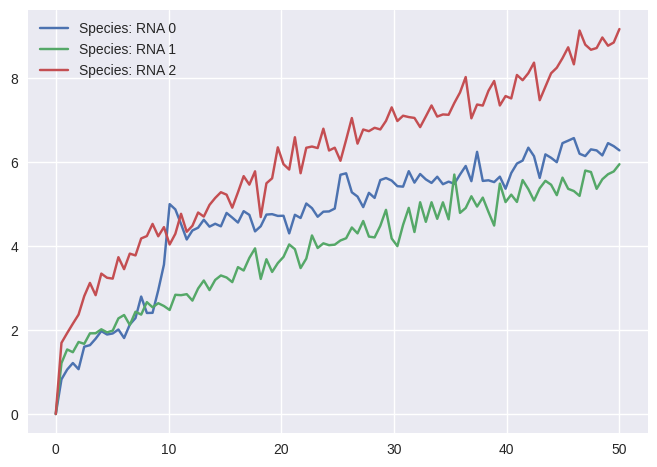

In [ ]:

plt.plot(big_result_2.ts[0], jnp.mean(np.array(big_result_2.ys.concentrations)[:, :, :3], axis = 0), label=med_model.species[:3])
plt.legend()

## Now with realistic parameters

In [ ]:
from src.utils.misc.units import per_mol_to_per_molecule

Keq = np.array(
    [[1, 2, 1],
     [2, 1, 0.5],
     [1, 0.5, 2]]
)
# From src/utils/common/configs/RNA_circuit/molecular_params.json
med_model_2 = bioreaction.templates.generate_rnabinding_medsim(
    num_species=3,
    a=np.ones(3) * 0.08333,
    d=np.ones(3) * 0.0008333,
    ka=np.ones((3, 3)) * per_mol_to_per_molecule(1000000),
    kd=ka/Keq,
    impulse_idx=0
)

impulse = Impulse(
    target=med_model_2.species[:3][signal_species_idx], delta_target=40, time=10.0, impulse_width=0.0)
med_model_2.impulses = [impulse]

poiss_simmed = jnp.zeros(len(med_model_2.reactions))
brown_simmed = jnp.ones(len(med_model_2.reactions))

# Making the params for the simulation, how things are simutated and for how long.
int_med_params = MedSimParams(delta_t=0.01, t_start=0.0, t_end=100.0,
                              poisson_sim_reactions=poiss_simmed, brownian_sim_reaction=brown_simmed)
int_med_model = get_int_med_model(med_model_2)

int_med_state = MedSimInternelState(concentrations=jnp.array(
    [starting_state.concentrations]), other_factors=jnp.zeros(len(med_model_2.other_factors)))


In [ ]:

def to_vmap_1(rng):
    return simulate_chunk(rng, int_med_state, int_med_model, int_med_params)
vmap_sim1 = jax.jit(jax.vmap(to_vmap_1))

rng_keys = jr.split(key, 100)
big_result_3 = vmap_sim1(rng_keys)

In [ ]:
big_result_3.ys.concentrations.shape

(100, 100, 1, 9)

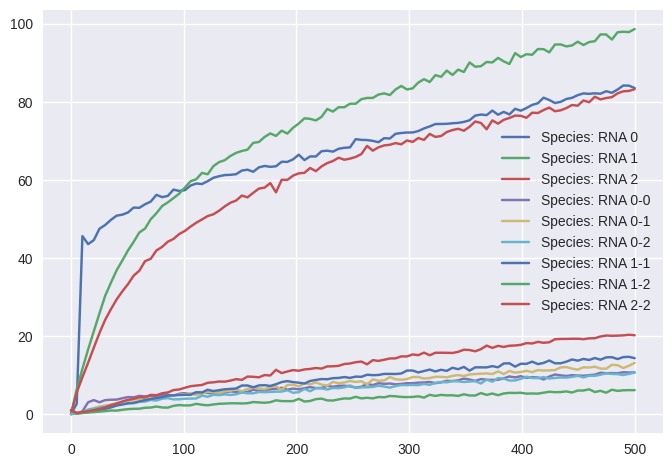

In [ ]:

plt.plot(big_result_3.ts[0], jnp.mean(np.array(big_result_3.ys.concentrations)[:, :, 0, :], axis = 0), label=med_model_2.species[:])
plt.legend()

In [ ]:
jax.config.update('jax_platform_name', 'gpu')
jax.devices()

[CpuDevice(id=0)]

In [ ]:

size = 5000
x = jr.normal(key, (size, size), dtype=jnp.float32)
%time x_jax = jax.device_put(x)  # 1. measure JAX device transfer time
%time jnp.dot(x_jax, x_jax.T).block_until_ready()  # 2. measure JAX compilation time
%timeit jnp.dot(x_jax, x_jax.T).block_until_ready() # 3. measure JAX running time

CPU times: user 78 µs, sys: 2 µs, total: 80 µs
Wall time: 84.9 µs
CPU times: user 4.37 s, sys: 47.9 ms, total: 4.42 s
Wall time: 458 ms
428 ms ± 9.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
